# HR ANALYTICS

In a particular company, deciding the ideal employee to be promoted has an entire process defined. The example that I have taken is a Binary Classification use case to select the potential employees suitable for a promotion. The features that decide the performance of the employees are:

**employee_id, department, region, education, gender, recruitment_channel, no_of_trainings, age, previous_year_rating, length_of_service, KPI's_met>80%, awards_won, avg_training_score**

The target label is **is_promoted**


In [6]:
from google.colab import files
import io
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [5]:
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV,RandomizedSearchCV
from sklearn.metrics import f1_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from xgboost.sklearn import XGBClassifier

In [4]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [8]:
uploaded = files.upload()
df = pd.read_csv(io.BytesIO(uploaded['HR analytics.csv']))

Saving HR analytics.csv to HR analytics (1).csv


In [9]:
df.drop(['employee_id'],axis=1,inplace=True)

In [10]:
# COLUMN_NAMES, CATEGORICAL_COLUMNS, NUMERICAL_COLUMNS
columns = df.columns.to_list()
categorical = [feature for feature in columns if df[feature].dtypes == 'O']
numerical = [feature for feature in columns if feature not in categorical]

In [11]:
# NULL values
for feature in columns:
  print(feature,':',df[feature].isna().sum()/len(df[feature]))

department : 0.0
region : 0.0
education : 0.04395343745438622
gender : 0.0
recruitment_channel : 0.0
no_of_trainings : 0.0
age : 0.0
previous_year_rating : 0.07524448985549555
length_of_service : 0.0
KPIs_met >80% : 0.0
awards_won? : 0.0
avg_training_score : 0.0
is_promoted : 0.0


Education has **4.39%** missing values
previous_year_rating has **7.52%** missing values

In [12]:
# UNIQUE VALUES in categorical
for feature in categorical:
  print(feature,':',len(df[feature].unique()))

department : 9
region : 34
education : 4
gender : 2
recruitment_channel : 3


In [13]:
# UNIQUE VALUES in numerical
for feature in numerical:
  print(feature,':',len(df[feature].unique()))

no_of_trainings : 10
age : 41
previous_year_rating : 6
length_of_service : 35
KPIs_met >80% : 2
awards_won? : 2
avg_training_score : 61
is_promoted : 2


*   **department, region, gender, recruitment channel** are nominal variables
*   **education** is an ordinal variable
*   All **Numerical** variables are descrete 






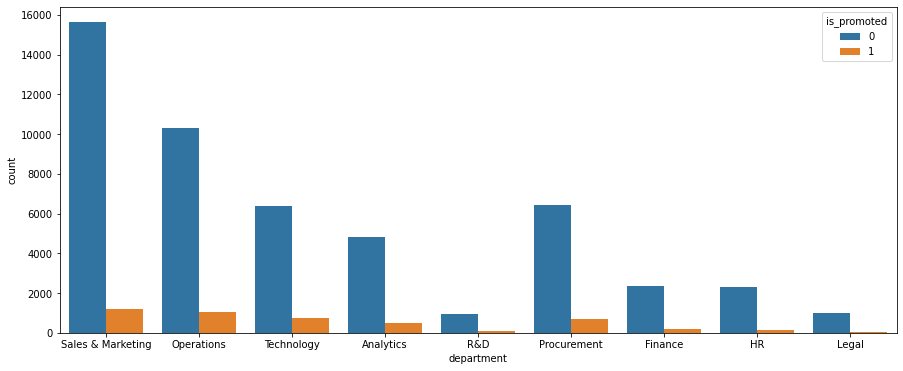

In [14]:
# Number of promoted and non promoted employees in various departments
plt.figure(figsize=(15,6))
sns.countplot(df['department'], hue=df['is_promoted'])

Most of the employees are from **Sales and Marketing** AND Sales & Marketing, Operations, Technology, Procurement are the departments where most of the promotions have taken place 

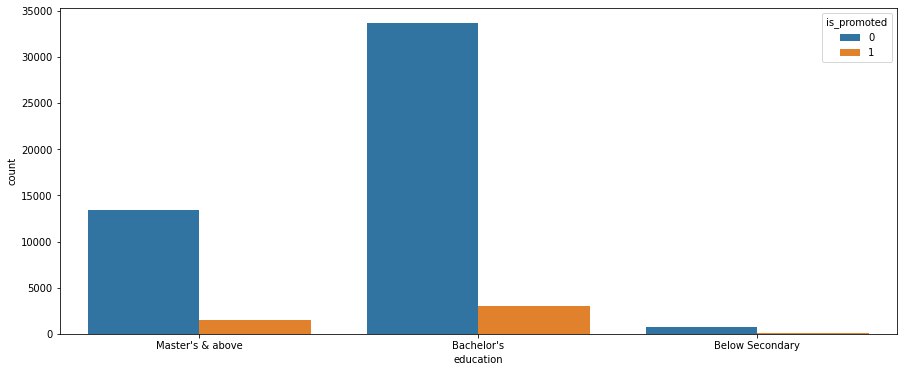

In [15]:
# Number of promoted and non promoted employees with respect to their education
plt.figure(figsize=(15,6))
sns.countplot(df['education'], hue=df['is_promoted'])

More number of employees with a Bachelor's degree have been promoted as compared to employees with masters degree. 

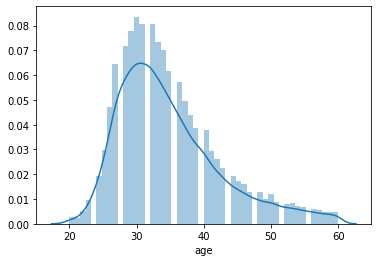

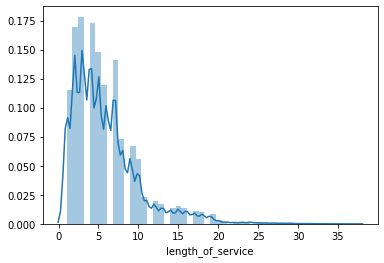

In [16]:
# Distribution of Numerical Features
sns.distplot(df['age'])
plt.show()
sns.distplot(df['length_of_service'])
plt.show()

Most of the employees are in their early 30's and the length of service is also around 3 - 7. Hence both these variables are positively skewed

0    91.482995
1     8.517005
Name: is_promoted, dtype: float64


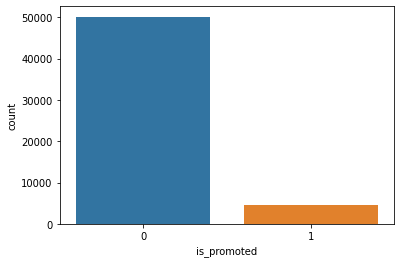

In [17]:
# Count of label class
print(df['is_promoted'].value_counts(normalize=True)*100)
sns.countplot(df['is_promoted'])

The class label is highly imbalanced **9:1** and so an upsampling approach will be implemented

##IMPUTING MISSING Values

In [18]:
# IMPUTING MISSING VALUES

df['education'].fillna(df['education'].mode()[0],inplace=True)
df['previous_year_rating'].fillna(df['previous_year_rating'].mean(),inplace=True)

##ENCODING CATEGORICAL VARIABLES 

In [19]:
# EDUCATION - Masters > Bachelors > Below Secondary
education_map = {"Master's & above":3,"Bachelor's":2,"Below Secondary":1}
df['education'] = df['education'].map(education_map)
categorical.remove('education')

In [20]:
# LABEL ENCODING for other categorical features
for feature in categorical:
  str_feature = df[feature].astype(str)
  df[feature] = le.fit_transform(str_feature)

##FEATURE CREATION

*   **TOTAL SCORE**   Average training score * Number of trainings 
*   **Award_KPI**   Awards won + KPI's met.
*   **Experience**   Age - Length of service






In [21]:
df['total_score'] = df['avg_training_score']*df['no_of_trainings']
df['award_kpi'] = df['awards_won?']+df['KPIs_met >80%']
df['experience'] = df['age'] - df['length_of_service']

##CORELATION between Features and Target

In [22]:
# Corelation b/w target and features
df[columns].corr().loc['is_promoted'].sort_values(ascending=False)

is_promoted             1.000000
KPIs_met >80%           0.221582
awards_won?             0.195871
avg_training_score      0.181147
previous_year_rating    0.153406
education               0.028026
region                  0.008841
recruitment_channel     0.002229
department              0.000130
length_of_service      -0.010670
gender                 -0.011109
age                    -0.017166
no_of_trainings        -0.024896
Name: is_promoted, dtype: float64

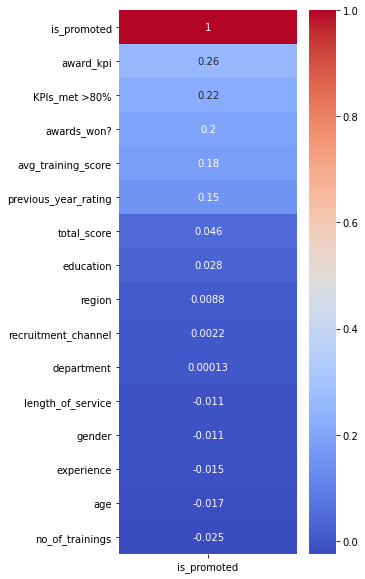

In [23]:
plt.figure(figsize=(4,10))
sns.heatmap(df.corr()[['is_promoted']].sort_values(by=['is_promoted'],ascending=False),cmap='coolwarm',annot=True,)

##OVER_SAMPLING USING SMOTE

In [24]:
df1 = df.copy()
x = df1.drop(['is_promoted'],axis=1)
y = df1['is_promoted']

In [25]:
oversample = SMOTE()
x1,y1 = oversample.fit_resample(x,y)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [26]:
# Train Test Split
x_train,x_test,y_train,y_test = train_test_split(x1,y1,test_size=0.2,random_state=42)

##Defining MODELS

###Random Forest Classifier

In [41]:
# Random ForesT Classifier using GRIDSEARCHCV

param_grid = {'criterion':['gini','entropy'],
              'n_estimators':[100,200,400]
              }
rfc = RandomForestClassifier()
grid_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, n_jobs=-1, cv = 3)

In [43]:
grid_rfc.fit(x_train,y_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [44]:
grid_rfc.best_estimator_

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [51]:
pred_rfc = grid_rfc.predict(x_test)
print('Classification Report : \n', classification_report(y_test, pred_rfc))
print('Accuracy : ',grid_rfc.score(x_test,y_test))

Classification Report : 
               precision    recall  f1-score   support

           0       0.95      0.99      0.97     10197
           1       0.99      0.94      0.96      9859

    accuracy                           0.97     20056
   macro avg       0.97      0.97      0.97     20056
weighted avg       0.97      0.97      0.97     20056

Accuracy :  0.9661946549660949


###ANN

In [52]:
from keras.models import Sequential
from keras.layers import Dense, Dropout

In [54]:
model = Sequential()
model.add(Dense(300, input_dim = 15, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(150, activation = 'relu'))
model.add(Dense(1, activation='sigmoid'))

In [55]:
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [61]:
model.fit(x_train,y_train,epochs=10,batch_size=100)

Epoch 1/10
803/803 [==============================] - 3s 3ms/step - loss: 0.4921 - accuracy: 0.7600
Epoch 2/10
803/803 [==============================] - 5s 6ms/step - loss: 0.4708 - accuracy: 0.7717
Epoch 3/10
803/803 [==============================] - 5s 7ms/step - loss: 0.4606 - accuracy: 0.7755
Epoch 4/10
803/803 [==============================] - 4s 5ms/step - loss: 0.4617 - accuracy: 0.7747
Epoch 5/10
803/803 [==============================] - 3s 4ms/step - loss: 0.4537 - accuracy: 0.7799
Epoch 6/10
803/803 [==============================] - 3s 3ms/step - loss: 0.4507 - accuracy: 0.7816
Epoch 7/10
803/803 [==============================] - 3s 3ms/step - loss: 0.4411 - accuracy: 0.7853
Epoch 8/10
803/803 [==============================] - 3s 3ms/step - loss: 0.4334 - accuracy: 0.7881
Epoch 9/10
803/803 [==============================] - 3s 3ms/step - loss: 0.4235 - accuracy: 0.7947
Epoch 10/10
803/803 [==============================] - 3s 3ms/step - loss: 0.4158 - accuracy: 0.7968

In [63]:
accuracy = model.evaluate(x_test,y_test)

627/627 [==============================] - 1s 1ms/step - loss: 0.3958 - accuracy: 0.8024


In [64]:
print('accuracy : ', accuracy[1], '\n loss : ', accuracy[0])

accuracy :  0.8024032711982727 
 loss :  0.39577966928482056


###XGBClassifier

In [67]:
params_xgb = {"learning_rate" : [0.05, 0.10, 0.15] ,
              "max_depth" : [ 3, 4, 5],
              "min_child_weight" : [ 1, 3],
              "gamma" : [ 0.1, 0.2 , 0.3],
              "colsample_bytree" : [ 0.3, 0.4] }
xgb = XGBClassifier()
ran_xgb = RandomizedSearchCV(estimator=xgb, param_distributions=params_xgb,n_iter=5,n_jobs=-1)

In [68]:
ran_xgb.fit(x_train,y_train)

RandomizedSearchCV(cv=None, error_score=nan,
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=100,
                                           n_jobs=1, nthread=None,
                                           objective='binary:logistic',
                                           random_state=0, reg_alpha=0,
                                           reg_lambda=1...le_pos_weight=1,
                                           seed=None, silent=None, subsample=1,
                                           verbosity=1),
                   iid='d

In [69]:
ran_xgb.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.3, gamma=0.2,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [71]:
ran_xgb.best_params_

{'colsample_bytree': 0.3,
 'gamma': 0.2,
 'learning_rate': 0.1,
 'max_depth': 5,
 'min_child_weight': 1}

In [73]:
pred_xgb = ran_xgb.predict(x_test)
print('Classification Report : \n', classification_report(y_test, pred_xgb))
print('Accuracy : ',ran_xgb.score(x_test,y_test))

Classification Report : 
               precision    recall  f1-score   support

           0       0.91      1.00      0.95     10197
           1       1.00      0.90      0.95      9859

    accuracy                           0.95     20056
   macro avg       0.96      0.95      0.95     20056
weighted avg       0.95      0.95      0.95     20056

Accuracy :  0.9504387714399681
